# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [12]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [13]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


## Helper Functions (complete or modify as needed)

In [14]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

In [15]:
X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
base_mae

1.278316828696949

## Parametric vs Bootstrap CI (Required)

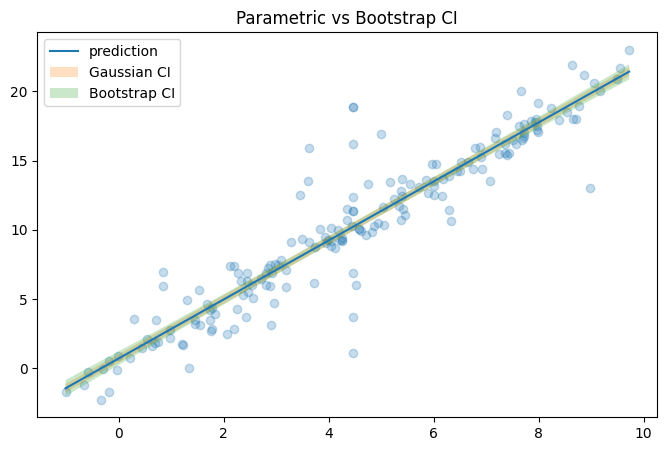

In [16]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

Since both CI methods agree closely, the linear model is stable and the homoscedasticity assumption holds.

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [17]:
# Here we are doing mean vs median and imputation vs dropping missing
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.278317,2.130236,0.711523
1,median_impute,1.283954,2.129290,0.727146
2,drop_missing,2.061050,2.130236,0.659164


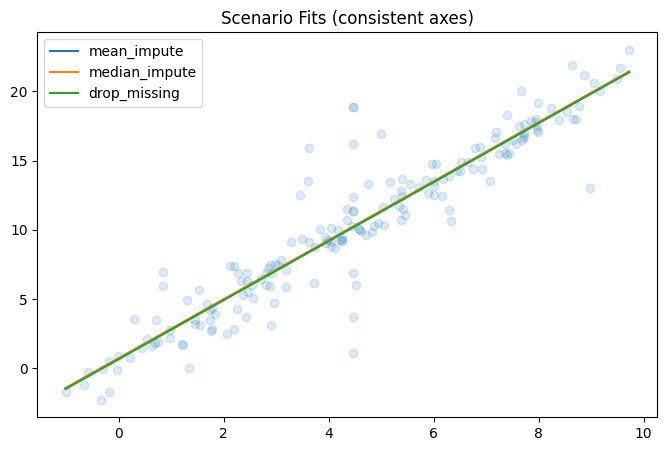

In [18]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

## Subgroup Diagnostic (Required)

In [19]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.066306,1.827501,-0.235648,94
B,0.294967,1.707514,-0.077390,41
C,-0.130242,2.813215,-0.140354,45


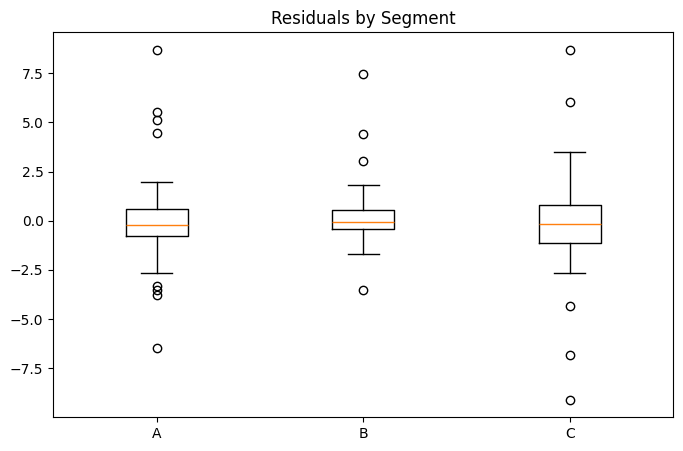

In [20]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


## Bootstrap a Metric (Required)

In [21]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 1.2714062440720526, 'lo': 1.0550822262814075, 'hi': 1.530997972363559}

## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”

- We assume that the relationship between the feature (x_feature) and the outcome (y_target) is approximately linear, and also assume the homoscedasticity.
- For the sensitivity, we compared two senarios for handling missing values: mean imputation vs median imputation, and filling(mean imputation) vs dropping. In both senarios, two approaches produce similar regression slopes and intercepts, indicating that all the approaches are reasonable.
- For the subgroup risks, segment A and C have a slightly higher spread thatn segment B, indicating potential heterogeneity.
- Predictions hold if the relationship between the feature (x_feature) and the outcome (y_target) remains approximately linear; the model is sensitive to the subgroup difference.
